In [1]:
import pandas as pd
from numpy import random
import os
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
#import seaborn as sns

In [2]:
base_path = os.getcwd()

players_file = os.path.join(base_path, "Datos", "players_22.csv")
players = pd.read_csv(players_file, header=0, encoding="utf-8")

features = ["overall", "potential", "wage_eur", "value_eur", "age"]
players = players.dropna(subset=features)

data = players[features].copy()

data.head()

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_5572\1932362028.py:4: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  players = pd.read_csv(players_file, header=0, encoding="utf-8")


,overall,potential,wage_eur,value_eur,age
0,93,93,320000.0,78000000.0,34
1,92,92,270000.0,119500000.0,32
2,91,91,270000.0,45000000.0,36
3,91,91,270000.0,129000000.0,29
4,91,91,350000.0,125500000.0,30


[3 3 3 ... 4 4 4]


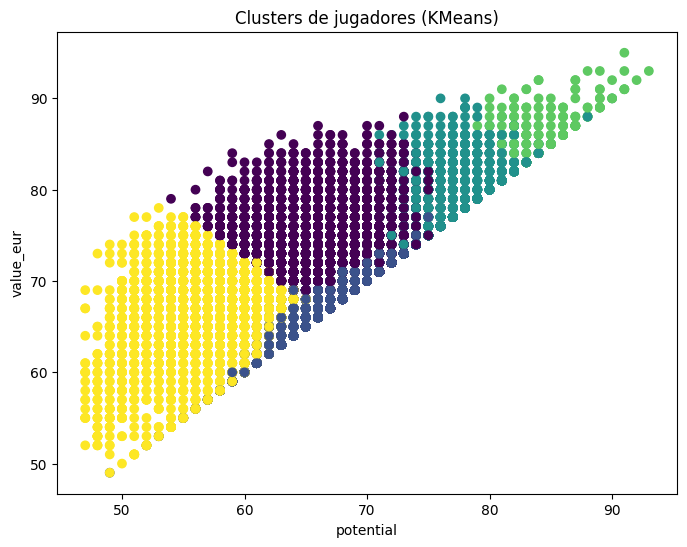

In [3]:
model = KMeans(n_clusters=5) #Algoritmo

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(scale(data)) # Entrenamiento #Investigar si se puede guardar en .PKL

# We can look at the clusters each data point was assigned to
print(model.labels_)

# And we'll visualize it:
plt.figure(figsize=(8, 6))
plt.scatter(
    x=data.iloc[:, 0],
    y=data.iloc[:, 1],
    c=model.labels_.astype(float),
    cmap='viridis'
)
plt.xlabel(data.columns[1])
plt.ylabel(data.columns[3])
plt.title("Clusters de jugadores (KMeans)")
plt.show()